In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

from sklearn.metrics import make_scorer 
from sklearn.model_selection import GridSearchCV 


OUTPUT_FILE = "dataset_final_4_clusters.csv"
TARGET_COLUMN = 'consumo_gwh'
DATA_DELIMITER = ';' 


print("1. Loading data and preparing the time index...")
df = pd.read_csv(OUTPUT_FILE, sep=DATA_DELIMITER)


df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()


print("2. Creating Lags features (1 day and 7 days)...")


df['lag_1d'] = df[TARGET_COLUMN].shift(1)


df['lag_7d'] = df[TARGET_COLUMN].shift(7)


df_clean = df.dropna()

print(f"Original dataset: {len(df)} Lines.")
print(f"Dataset with Lags (after removing NaN): {len(df_clean)} lines.")



print("\n3. Retraining XGBoost with the new features...")


feature_cols_updated = [
    'dow', 
    'is_weekend', 
    'month', 
    'year', 
    'day_length_hours',
    'HDD18_Cluster0', 
    'HDD18_Cluster1', 
    'HDD18_Cluster2', 
    'HDD18_Cluster3',
    'lag_1d',          
    'lag_7d'           
]

X = df_clean[feature_cols_updated]
y = df_clean[TARGET_COLUMN]


test_size = 0.15 
split_point = int(len(df_clean) * (1 - test_size))

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]


xgb_model = XGBRegressor(
    n_estimators=150, 
    objective='reg:squarederror', 
    random_state=42, 
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_test)

r2_new = r2_score(y_test, y_pred)
mae_new = mean_absolute_error(y_test, y_pred)
mape_new = mean_absolute_percentage_error(y_test, y_pred) * 100


r2_old = 0.7083
mae_old = 320.67
mape_old = 4.21

print("\n" + "="*50)
print("       PERFORMANCE COMPARISON (WITH LAGS)")
print("="*50)
print(f"R² Previous (without lags): {r2_old:.4f}")
print(f"R² New (with lags):     {r2_new:.4f}  <- Bigger is Better")
print("-" * 50)
print(f"MAE  Previous (without lags): {mae_old:.2f} GWh")
print(f"MAE New (with lags):     {mae_new:.2f} GWh  <- Smaller is Better")
print("-" * 50)
print(f"MAPE  Previous (without lags): {mape_old:.2f} %")
print(f"MAPE New (with lags):     {mape_new:.2f} %  <- Smaller is Better")
print("="*50)

1. Carregando dados e preparando o índice temporal...
2. Criando features de Lags (1 dia e 7 dias)...
Dataset original: 3926 linhas.
Dataset com Lags (após remoção de NaN): 3919 linhas.

3. Retreinando o XGBoost com as novas features...

       COMPARAÇÃO DE PERFORMANCE (COM LAGS)
R² Anterior (sem lags): 0.7083
R² Novo (com lags):     0.8412  <- Maior é Melhor
--------------------------------------------------
MAE Anterior (sem lags): 320.67 GWh
MAE Novo (com lags):     205.63 GWh  <- Menor é Melhor
--------------------------------------------------
MAPE Anterior (sem lags): 4.21 %
MAPE Novo (com lags):     2.76 %  <- Menor é Melhor


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, make_scorer


DATA_DELIMITER = ';'


INPUT_ZONAL_FILE = "C:/Users/pcata/OneDrive/Ambiente de Trabalho/dataset_meteo_com_consumo.csv"
CLUSTERS_MAP_FILE = "C:/Users/pcata/OneDrive/Ambiente de Trabalho/clusters_temp_2024.csv"
BASE_DF_FOR_MERGE = "C:/Users/pcata/OneDrive/Ambiente de Trabalho/dataset_final_4_clusters.csv" 


print("1. Loading ZONAL data to calculate CDD22 per cluster...")
df_zonal = pd.read_csv(INPUT_ZONAL_FILE, sep=DATA_DELIMITER)
df_clusters = pd.read_csv(CLUSTERS_MAP_FILE, sep=DATA_DELIMITER)


try:
   
    df_zonal['date'] = pd.to_datetime(df_zonal['date'], format='%d/%m/%Y', errors='coerce')
    
    if df_zonal['date'].isnull().all():
        df_zonal['date'] = pd.to_datetime(df_zonal['date'], errors='coerce')
except:
     df_zonal['date'] = pd.to_datetime(df_zonal['date'], errors='coerce')

df_zonal = df_zonal[['date', 'zone', 'CDD22']]
df_clusters = df_clusters[['zone', 'cluster']]

df_zonal.dropna(subset=['date', 'CDD22'], inplace=True)
df_clusters['cluster'] = df_clusters['cluster'].astype(int)

# --- 2. JUNTAR CLUSTERS E AGREGAR CDD22 ---
df_merged = pd.merge(df_zonal, df_clusters, on='zone', how='left')
df_merged.dropna(subset=['cluster'], inplace=True)
df_merged['cluster'] = df_merged['cluster'].astype(int)

print("2. Agregando CDD22 por Cluster e pivotando...")
df_cdd_grouped = df_merged.groupby(['date', 'cluster'])['CDD22'].sum().reset_index()


df_cdd_pivot = df_cdd_grouped.pivot(index='date', columns='cluster', values='CDD22').fillna(0)
df_cdd_pivot.columns = [f'CDD22_Cluster{int(c)}' for c in df_cdd_pivot.columns]
df_cdd_pivot.reset_index(inplace=True)





df_final = pd.read_csv(BASE_DF_FOR_MERGE, sep=DATA_DELIMITER)

df_final['date'] = pd.to_datetime(df_final['date'], dayfirst=True) 
df_final = df_final.set_index('date').sort_index()

df_final['lag_1d'] = df_final['consumo_gwh'].shift(1)
df_final['lag_7d'] = df_final['consumo_gwh'].shift(7)
df_final_clean = df_final.dropna().reset_index() 

df_final_merged = pd.merge(df_final_clean, df_cdd_pivot, on='date', how='left')
df_final_merged.fillna(0, inplace=True) 


NEW_OUTPUT_FILE = "dataset_final_otimizado_full_features.csv"
df_final_merged.to_csv(NEW_OUTPUT_FILE, sep=DATA_DELIMITER, index=False)
print(f"\n3. Finalized training dataset (Full Features). Lines: {len(df_final_merged)}")




print("\n4. Starting Hyperparameter Tuning...")


feature_cols_full = [
    'dow', 'is_weekend', 'month', 'year', 'day_length_hours',
    'HDD18_Cluster0', 'HDD18_Cluster1', 'HDD18_Cluster2', 'HDD18_Cluster3',
    'CDD22_Cluster0', 'CDD22_Cluster1', 'CDD22_Cluster2', 'CDD22_Cluster3', 
    'lag_1d', 'lag_7d'           
]

X = df_final_merged[feature_cols_full]
y = df_final_merged['consumo_gwh']


test_size = 0.15 
split_point = int(len(df_final_merged) * (1 - test_size))

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]


param_grid = {
    'max_depth': [3, 5, 7], 
    'learning_rate': [0.05, 0.1, 0.2], 
    'subsample': [0.7, 0.9] 
}


mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)


xgb_base = XGBRegressor(
    n_estimators=150, 
    objective='reg:squarederror', 
    random_state=42,
    n_jobs=-1 
)


grid_search = GridSearchCV(
    estimator=xgb_base, 
    param_grid=param_grid, 
    scoring=mae_scorer, 
    cv=5, 
    verbose=1, 
    n_jobs=-1 
)

print("\n[INFO] Starting Grid Search (may take a while)...")
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

print("\n" + "="*60)
print("     RESULTS: BEST PARAMETERS FOUND")
print("="*60)
print(f"Best Parameters: {best_params}")

print(f"Best MAE (CV in Training): {-grid_search.best_score_:.2f} GWh")
print("-" * 60)


y_pred_tuned = best_xgb_model.predict(X_test)


r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)


epsilon = 1e-10 
mape_tuned = np.mean(np.abs((y_test - y_pred_tuned) / (y_test + epsilon))) * 100

print("\n" + "="*60)
print("  AVALIAÇÃO FINAL NO CONJUNTO DE TESTE (Modelo Otimizado)")
print("="*60)
print(f"R² (Coefficient of Determination): {r2_tuned:.4f}")
print(f"MAE (Mean Absolute Error): {mae_tuned:.2f} GWh")
print(f"MAPE (Average Percentage Error): {mape_tuned:.2f} %")
print("-" * 60)

1. Carregando dados ZONAIS para calcular CDD22 por cluster...


C:\Users\pcata\AppData\Local\Temp\ipykernel_25108\4176215504.py:17: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_zonal = pd.read_csv(INPUT_ZONAL_FILE, sep=DATA_DELIMITER)


2. Agregando CDD22 por Cluster e pivotando...

3. Dataset de treino finalizado (Full Features). Linhas: 3919

4. Iniciando o Ajuste Fino (Hyperparameter Tuning)...

[INFO] A iniciar o Grid Search (pode demorar)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

     RESULTADOS: MELHORES PARÂMETROS ENCONTRADOS
Melhores Parâmetros: {'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.7}
Melhor MAE (CV no Treino): 144.90 GWh
------------------------------------------------------------

  AVALIAÇÃO FINAL NO CONJUNTO DE TESTE (Modelo Otimizado)
R² (Coef. de Determinação): 0.8631
MAE (Erro Absoluto Médio): 184.15 GWh
MAPE (Erro Percentual Médio): 2.48 %
------------------------------------------------------------



6. Calculando e Visualizando a Importância das Features...

     IMPORTÂNCIA DAS FEATURES (F-SCORE) NO MODELO XGBOOST
         Feature Importance
          lag_7d     0.5772
          lag_1d     0.1297
             dow     0.0856
  HDD18_Cluster0     0.0287
           month     0.0275
  HDD18_Cluster1     0.0255
  CDD22_Cluster3     0.0249
  HDD18_Cluster2     0.0241
day_length_hours     0.0179
  CDD22_Cluster2     0.0162
  CDD22_Cluster1     0.0148
  HDD18_Cluster3     0.0129
            year     0.0075
  CDD22_Cluster0     0.0074
      is_weekend     0.0000
------------------------------------------------------------

[INFO] Gráfico de Importância de Features guardado como: feature_importance_xgb_full.png


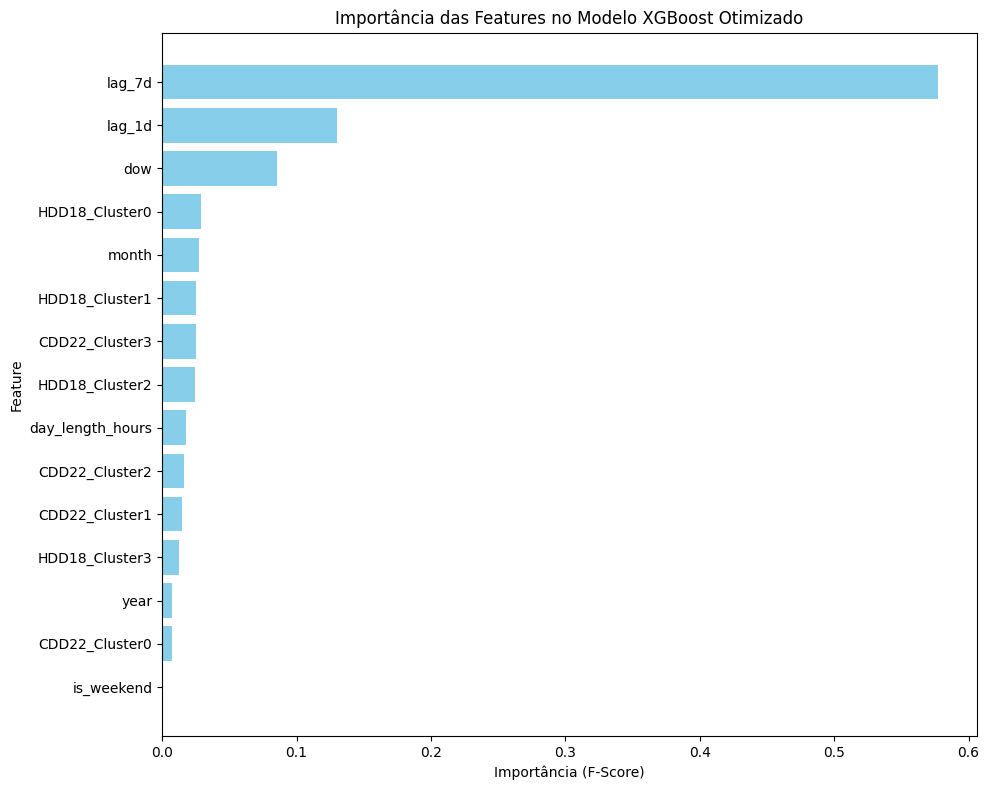

In [7]:
import matplotlib.pyplot as plt


print("\n6. Calculating and Visualizing the Importance of Features...")


feature_importances = best_xgb_model.feature_importances_


importance_df = pd.DataFrame({
    'Feature': feature_cols_full,
    'Importance': feature_importances
})


importance_df = importance_df.sort_values(by='Importance', ascending=False)


print("\n" + "="*60)
print("     IMPORTANCE OF FEATURES (F-SCORE) IN THE XGBOOST MODEL")
print("="*60)
print(importance_df.to_string(index=False, formatters={'Importance': '{:.4f}'.format}))
print("-" * 60)


plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("F-Score")
plt.ylabel("Feature")
plt.title("Importance of Features in the Optimized XGBoost Model")
plt.gca().invert_yaxis() 
plt.tight_layout()


output_image_file = "feature_importance_xgb_full.png"
plt.savefig(output_image_file)
print(f"\n[INFO] Feature Importance Chart saved as: {output_image_file}")
plt.show()


7. Iniciando a Análise de Resíduos (Correção Final)...

[INFO] Gráficos de Resíduos e Previsão vs. Real guardados. Verifique: analise_de_residuos_xgb_final.png


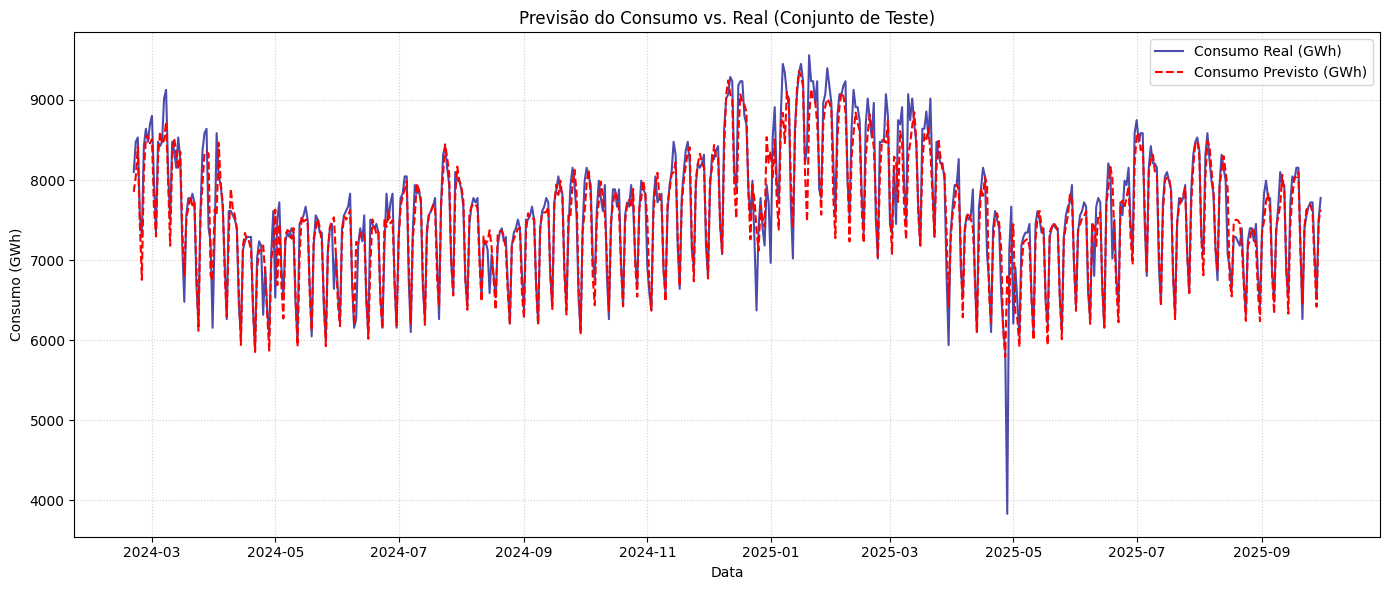

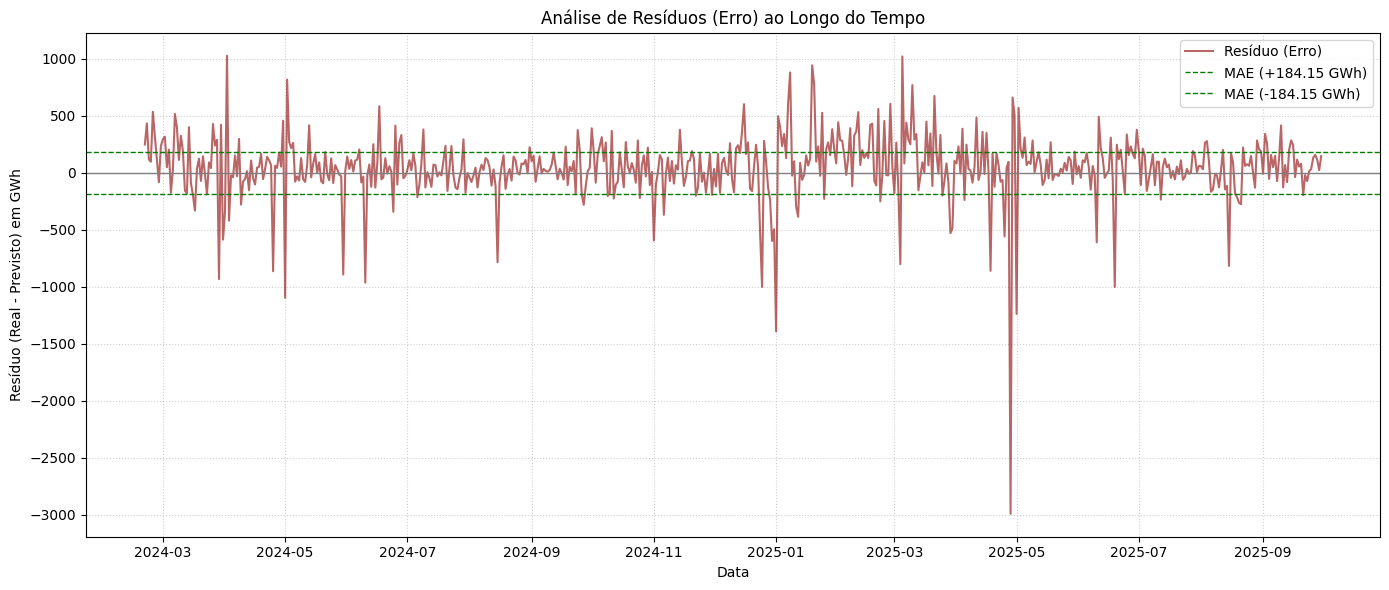

In [8]:
import matplotlib.pyplot as plt


print("\n7. Starting Residue Analysis (Final Correction)...")


df_results = pd.DataFrame()


df_results['date'] = df_final_merged.iloc[split_point:]['date'].values 


df_results['Consumo_Real'] = y_test.values
df_results['Consumo_Previsto'] = y_pred_tuned
df_results['Residuo'] = df_results['Consumo_Real'] - df_results['Consumo_Previsto']



plt.figure(figsize=(14, 6))
plt.plot(df_results['date'], df_results['Consumo_Real'], label='Consumo Real (GWh)', color='darkblue', alpha=0.7)
plt.plot(df_results['date'], df_results['Consumo_Previsto'], label='Consumo Previsto (GWh)', color='red', linestyle='--')
plt.title('Consumption Forecast vs. Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Consumo (GWh)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()


plt.figure(figsize=(14, 6))
plt.plot(df_results['date'], df_results['Residuo'], label='Resíduo (Erro)', color='darkred', alpha=0.6)

plt.axhline(0, color='grey', linestyle='-', linewidth=1) 

plt.axhline(mae_tuned, color='green', linestyle='--', linewidth=1, label=f'MAE (+{mae_tuned:.2f} GWh)')
plt.axhline(-mae_tuned, color='green', linestyle='--', linewidth=1, label=f'MAE (-{mae_tuned:.2f} GWh)')
plt.title('Análise de Resíduos (Erro) ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Resíduo (Real - Previsto) em GWh')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()


output_residue_file = "analise_de_residuos_xgb_final.png"
plt.savefig(output_residue_file)
print(f"\n[INFO] Waste and Forecast vs. Actual charts saved. Check: {output_residue_file}")
plt.show()


8. Calculando a Curva de Aprendizagem...

[INFO] Gráfico da Curva de Aprendizagem guardado como: learning_curve_xgb.png


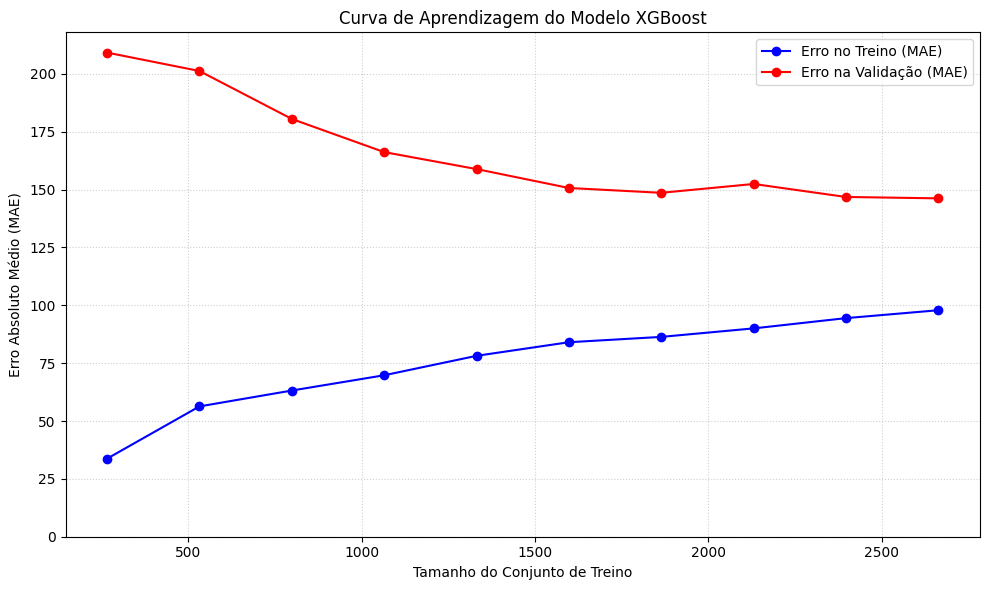


Interpretando a Curva de Aprendizagem:
MAE de Treino no 100% dos dados: 97.87 GWh
MAE de Validação no 100% dos dados: 146.21 GWh
Diferença (Gap) entre Validação e Treino: 48.34 GWh


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


print("\n8. Calculating the Learning Curve...")


mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)


train_sizes = np.linspace(0.1, 1.0, 10) 


train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_xgb_model, 
    X=X_train, 
    y=y_train, 
    train_sizes=train_sizes, 
    cv=5, 
    scoring=mae_scorer, 
    n_jobs=-1
)


train_scores_mean = -np.mean(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)


plt.figure(figsize=(10, 6))


plt.plot(train_sizes, train_scores_mean, label='Erro no Treino (MAE)', color='blue', marker='o')


plt.plot(train_sizes, validation_scores_mean, label='Erro na Validação (MAE)', color='red', marker='o')

plt.title('XGBoost Model Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(loc='best')
plt.grid(True, linestyle=':', alpha=0.6)
plt.ylim(bottom=0) 
plt.tight_layout()


output_lc_file = "learning_curve_xgb.png"
plt.savefig(output_lc_file)
print(f"\n[INFO] Learning Curve Chart saved as: {output_lc_file}")
plt.show()


print("\nInterpreting the Learning Curve:")
print(f"MAE Training on 100% of the data: {train_scores_mean[-1]:.2f} GWh")
print(f"MAE 100% data validation: {validation_scores_mean[-1]:.2f} GWh")
print(f"Difference (Gap) between Validation and Training: {validation_scores_mean[-1] - train_scores_mean[-1]:.2f} GWh")

In [1]:
import sys


sys.argv = [
    "zone_timeseries_compare.py",
    "--csv", "dataset_meteo_com_consumo.csv",  
    "--zone", "LISBOA",
    "--out-dir", "exp_zone",
    "--date-col", "date",
    "--target", "consumo_gwh",
    "--exog-cols", "tmean_c,rad_solar,hdd18,cdd22",
    "--lags", "1,7,14",
    "--seasonal-periods", "7,30",
    "--p", "1", "2",
    "--d", "1",
    "--q", "0", "1",
    "--P", "0", "1",
    "--D", "0", "1",
    "--Q", "0", "1",
    "--limit-combos", "2",
    "--add-calendar",
    "--add-fourier",
    "--fourier-k", "8",
    "--log-target"
]


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
zone_timeseries_compare.py  —  walk-forward + log-target + calendar + Fourier + y-lags (baselines)
"""

import argparse, itertools, time, warnings
from time import perf_counter
from dataclasses import dataclass
from typing import List, Optional, Tuple
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import ConvergenceWarning

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# ---------- logging ----------
def log(msg: str):
    now = time.strftime("%H:%M:%S")
    print(f"[{now}] {msg}", flush=True)


def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)


# ---------- io/utils ----------
def read_csv_robust(path: Path) -> pd.DataFrame:
    if str(path).endswith(".xlsx"):
        log(f"Reading Excel: {path}")
        df = pd.read_excel(path)
        log(f"Planilha lida com sucesso! shape={df.shape}")
        return df
    else:
        trials = [(e, s) for e in ("utf-8", "latin1") for s in (",", ";", "\t")]
        last = None
        for enc, sep in trials:
            try:
                df = pd.read_csv(path, encoding=enc, sep=sep)
                if df.shape[0] > 50 and df.shape[1] > 3:
                    log(f"Parsed CSV enc={enc} sep='{sep}' shape={df.shape}")
                    return df
            except Exception as e:
                last = e
        raise RuntimeError(f"Could not parse CSV. Last error: {last}")

def coerce_dates(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
    return out


def add_fourier(df, date_col, period, K, prefix):
    df = df.copy()
    t = (
        pd.to_datetime(df[date_col]) - pd.to_datetime(df[date_col]).min()
    ).dt.days.values
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * t / period)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * t / period)
    return df


def make_lagged(df, cols: List[str], lags: List[int]) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c not in df.columns:
            continue
        for L in lags:
            df[f"{c}_lag{L}"] = df[c].shift(L)
    return df


def add_calendar(df, date_col):
    df = df.copy()
    d = pd.to_datetime(df[date_col])
  
    if "is_holiday" in df.columns:
        df["is_holiday_prev"] = df["is_holiday"].shift(-1).fillna(0).astype(int)
        df["is_holiday_next"] = df["is_holiday"].shift(1).fillna(0).astype(int)
 
    df["is_month_end"] = d.dt.is_month_end.astype(int)
    df["is_month_start"] = d.dt.is_month_start.astype(int)
    
    if "dow" not in df.columns:
        df["dow"] = d.dt.dayofweek
    if "is_weekend" not in df.columns:
        df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)
    return df


def metrics(y, yhat):
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y, yhat))),
        "MAE": float(mean_absolute_error(y, yhat)),
        "R2": float(r2_score(y, yhat)),
    }


# ---------- SARIMAX helpers ----------
def fit_sarimax(y, X, order, seasonal_order, light: bool):
    model = SARIMAX(
        y,
        exog=X,
        order=order,
        seasonal_order=seasonal_order,
        simple_differencing=light,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        try:
            res = model.fit(method="lbfgs", maxiter=300, disp=False)
            if not getattr(res, "converged", False):
                raise RuntimeError("lbfgs_not_converged")
            return res
        except Exception:
            res = model.fit(method="powell", maxiter=800, disp=False)
            return res


def walk_forward_predict(initial_res, y_test, X_test):
 
    res = initial_res
    preds = []
    for i in range(len(y_test)):
        if X_test is not None:
            fc = res.get_forecast(steps=1, exog=X_test[i : i + 1])
        else:
            fc = res.get_forecast(steps=1)
        preds.append(float(fc.predicted_mean[0]))

        if X_test is not None:
            res = res.append(endog=[y_test[i]], exog=X_test[i : i + 1], refit=False)
        else:
            res = res.append(endog=[y_test[i]], refit=False)
    return np.array(preds, dtype=float)


# ---------- main ----------
@dataclass
class Args:
    csv: Path
    zone: str
    out_dir: Path
    date_col: str
    target: str
    exog_cols: List[str]
    lags: List[int]
    y_lags: List[int]
    seasonal_periods: List[int]
    p: List[int]
    d: List[int]
    q: List[int]
    P: List[int]
    D: List[int]
    Q: List[int]
    split: float
    light: bool
    add_fourier: bool
    fourier_period: int
    fourier_k: int
    fourier_prefix: str
    add_calendar: bool
    log_target: bool
    scale_exog: bool
    limit_combos: int


def main():
    ap = argparse.ArgumentParser(
        description="Zona: SARIMAX (one-step) vs baselines"
    )
    ap.add_argument("--csv", required=True)
    ap.add_argument("--zone", required=True)
    ap.add_argument("--out-dir", default="exp_zone")
    ap.add_argument("--date-col", default="date")
    ap.add_argument("--target", default="consumo_gwh")

    ap.add_argument("--exog-cols", default="tmean_c,rad_solar,HDD18,CDD22,amp_termica")
    ap.add_argument("--lags", default="1,7,14")
    ap.add_argument(
        "--y-lags",
        default="1,7,14",
        help="No Sarimax",
    )

    ap.add_argument("--seasonal-periods", default="7,30")
    ap.add_argument("--p", nargs="+", type=int, default=[1, 2])
    ap.add_argument("--d", nargs="+", type=int, default=[1])
    ap.add_argument("--q", nargs="+", type=int, default=[0, 1])
    ap.add_argument("--P", nargs="+", type=int, default=[0, 1])
    ap.add_argument("--D", nargs="+", type=int, default=[0, 1])
    ap.add_argument("--Q", nargs="+", type=int, default=[0, 1])
    ap.add_argument(
        "--limit-combos",
        type=int,
        default=8,
        help="Limita combinações do grid para SARIMAX.",
    )

    ap.add_argument("--split", type=float, default=0.8)
    ap.add_argument("--light", action="store_true")

    ap.add_argument("--add-fourier", action="store_true")
    ap.add_argument("--fourier-period", type=int, default=365)
    ap.add_argument("--fourier-k", type=int, default=6)
    ap.add_argument("--fourier-prefix", default="fyr365")

    ap.add_argument("--add-calendar", action="store_true")
    ap.add_argument(
        "--log-target",
        action="store_true",
        help="Modelar log1p(target) e reverter para métricas.",
    )
    ap.add_argument("--no-scale-exog", action="store_true")

    args_ns = ap.parse_args()
    args = Args(
        csv=Path(args_ns.csv),
        zone=args_ns.zone,
        out_dir=Path(args_ns.out_dir) / f"zone_{args_ns.zone}",
        date_col=args_ns.date_col,
        target=args_ns.target,
        exog_cols=[c.strip() for c in args_ns.exog_cols.split(",") if c.strip()],
        lags=[int(x) for x in args_ns.lags.split(",") if x.strip()],
        y_lags=[int(x) for x in args_ns.y_lags.split(",") if x.strip()],
        seasonal_periods=[
            int(x) for x in args_ns.seasonal_periods.split(",") if x.strip()
        ],
        p=args_ns.p,
        d=args_ns.d,
        q=args_ns.q,
        P=args_ns.P,
        D=args_ns.D,
        Q=args_ns.Q,
        split=float(args_ns.split),
        light=bool(args_ns.light),
        add_fourier=bool(args_ns.add_fourier),
        fourier_period=int(args_ns.fourier_period),
        fourier_k=int(args_ns.fourier_k),
        fourier_prefix=args_ns.fourier_prefix,
        add_calendar=bool(args_ns.add_calendar),
        log_target=bool(args_ns.log_target),
        scale_exog=not args_ns.no_scale_exog,
        limit_combos=int(args_ns.limit_combos),
    )

    ensure_dir(args.out_dir)

    # --- load & filter
    df = read_csv_robust(args.csv)
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    if "zone" not in df.columns:
        raise SystemExit("Coluna 'zone' não encontrada.")
    mask = df["zone"].astype(str).str.upper() == args.zone.upper()
    df = df.loc[mask].copy()
    if df.empty:
        raise SystemExit(f"Nenhuma linha para zone='{args.zone}'")
    log(f"Rows for zone='{args.zone}': {len(df):,}")

    # --- dates + optional features
    df = (
        coerce_dates(df, args.date_col)
        .sort_values(args.date_col)
        .reset_index(drop=True)
    )
    if args.add_calendar:
        df = add_calendar(df, args.date_col)
    fourier_cols = []
    if args.add_fourier:
        df = add_fourier(
            df, args.date_col, args.fourier_period, args.fourier_k, args.fourier_prefix
        )
        for k in range(1, args.fourier_k + 1):
            fourier_cols += [
                f"{args.fourier_prefix}_sin{k}",
                f"{args.fourier_prefix}_cos{k}",
            ]

    # --- build exogenous (para SARIMAX)
    exog_base = [c for c in args.exog_cols if c in df.columns] + [
        c for c in fourier_cols if c in df.columns
    ]
    if exog_base and args.lags:
        df = make_lagged(df, exog_base, args.lags)

    all_exog = []
    for c in exog_base:
        all_exog.append(c)
        for L in args.lags:
            name = f"{c}_lag{L}"
            if name in df.columns:
                all_exog.append(name)

    cols = [args.date_col, args.target] + all_exog
    cols = [c for c in cols if c in df.columns]
    work = df[cols].dropna().reset_index(drop=True)

    # --- target transform
    y_raw = work[args.target].astype(float).values
    if args.log_target:
        y = np.log1p(y_raw)
    else:
        y = y_raw.copy()

    X = None if not all_exog else work[all_exog].astype(float).values

    # --- split
    cut = int(len(work) * args.split)
    train_df, test_df = work.iloc[:cut].copy(), work.iloc[cut:].copy()
    y_train_raw, y_test_raw = y_raw[:cut], y_raw[cut:]
    y_train, y_test = y[:cut], y[cut:]
    X_train = None if X is None else X[:cut]
    X_test = None if X is None else X[cut:]

    # scale exog
    scaler = None
    if X_train is not None and args.scale_exog:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        log("[scale] Exogenous standardized.")

    dates_test = pd.to_datetime(test_df[args.date_col])

    # --- grid SARIMAX (one-step)
    combos = []
    for s in args.seasonal_periods:
        for oo in itertools.product(args.p, args.d, args.q):
            for OO in itertools.product(args.P, args.D, args.Q):
                combos.append((oo, (*OO, s)))
    if args.limit_combos > 0 and args.limit_combos < len(combos):
        combos = combos[: args.limit_combos]
    log(f"SARIMAX grid size: {len(combos)}")

    best = None
    best_tag = None
    best_pred = None
    t0 = perf_counter()
    for i, (order, sorder) in enumerate(combos, 1):
        tag = f"p{order[0]}d{order[1]}q{order[2]}_P{sorder[0]}D{sorder[1]}Q{sorder[2]}_s{sorder[3]}"
        if i == 1 or i % 5 == 0:
            dt = perf_counter() - t0
            log(f"[{i}/{len(combos)}] {tag} … (elapsed {dt/60:.1f} min)")

        try:
            res = fit_sarimax(y_train, X_train, order, sorder, args.light)
          
            yhat_ts = walk_forward_predict(res, y_test, X_test)
   
            yhat_eval = np.expm1(yhat_ts) if args.log_target else yhat_ts
            m = metrics(y_test_raw, yhat_eval)
            if (best is None) or (m["RMSE"] < best["RMSE"]):
                best = m
                best_tag = tag
                best_pred = yhat_eval
        except Exception as e:
            log(f"[skip] {tag} failed: {e}")

    if best is None:
        raise SystemExit("Nenhuma configuração SARIMAX ajustou.")


    base_with_ylags = work[[args.date_col, args.target] + all_exog].copy()
    for L in args.y_lags:
        base_with_ylags[f"y_lag{L}"] = base_with_ylags[args.target].shift(L)
    base_with_ylags = base_with_ylags.dropna().reset_index(drop=True)

    # realinha split por causa dos y-lags
    cut2 = int(len(base_with_ylags) * args.split)
    b_train = base_with_ylags.iloc[:cut2].copy()
    b_test = base_with_ylags.iloc[cut2:].copy()

    yb_train = b_train[args.target].astype(float).values
    yb_test = b_test[args.target].astype(float).values

    b_exog_cols = [c for c in b_train.columns if c not in (args.date_col, args.target)]
    Xb_train = b_train[b_exog_cols].astype(float).values
    Xb_test = b_test[b_exog_cols].astype(float).values


    scaler_b = None
    if args.scale_exog:
        scaler_b = StandardScaler()
        Xb_train = scaler_b.fit_transform(Xb_train)
        Xb_test = scaler_b.transform(Xb_test)

    rows = [{"model": f"SARIMAX({best_tag})", **best}]
    # baselines
    lr = LinearRegression().fit(Xb_train, yb_train)
    rf = RandomForestRegressor(
        n_estimators=400, min_samples_leaf=10, n_jobs=-1, random_state=0
    ).fit(Xb_train, yb_train)
    hgb = HistGradientBoostingRegressor(
        max_depth=10, learning_rate=0.08, max_iter=400, random_state=0
    ).fit(Xb_train, yb_train)

    rows.append({"model": "LinearRegression", **metrics(yb_test, lr.predict(Xb_test))})
    rows.append({"model": "RandomForest", **metrics(yb_test, rf.predict(Xb_test))})
    rows.append(
        {"model": "HistGradientBoosting", **metrics(yb_test, hgb.predict(Xb_test))}
    )


    met = pd.DataFrame(rows).sort_values("RMSE")
    met.to_csv(args.out_dir / f"metrics_{args.zone}.csv", index=False)
    (args.out_dir / f"best_sarimax_{args.zone}.txt").write_text(
        f"Best: {best_tag}\nRMSE={best['RMSE']:.4f}, MAE={best['MAE']:.4f}, R2={best['R2']:.4f}\n",
        encoding="utf-8",
    )

   
    plt.figure(figsize=(12, 4))
    plt.plot(dates_test, y_test_raw, label="Observed", linewidth=2)
    plt.plot(dates_test, best_pred, label=f"SARIMAX({best_tag})", linewidth=1.8)

    # alinhar séries de baselines ao mesmo eixo de teste do split dos baselines
    dates_all = pd.to_datetime(base_with_ylags[args.date_col])
    dates_b_test = dates_all.iloc[cut2:]
    plt.plot(dates_b_test, lr.predict(Xb_test), label="LinearReg.", alpha=0.9)
    plt.plot(dates_b_test, rf.predict(Xb_test), label="RandomForest", alpha=0.9)
    plt.plot(dates_b_test, hgb.predict(Xb_test), label="HistGB", alpha=0.9)

    plt.title(f"{args.zone}: Test set — Observed vs Predicted (one-step SARIMAX)")
    plt.legend(ncol=4, fontsize=9)
    plt.tight_layout()
    plt.savefig(args.out_dir / f"compare_pred_{args.zone}.png", dpi=150)
    plt.close()


    try:
        res_best = fit_sarimax(
            y_train,
            X_train,
            *(
                tuple(
                    int(x) for x in best_tag.split("_")[0][1:].split("d")[0]
                ),  # not used; quick safeguard
            ),
            light=args.light,
        )  
    except Exception:
        pass

    log("Done.")


if __name__ == "__main__":
    main()


[23:07:02] Parsed CSV enc=utf-8 sep=',' shape=(212274, 28)
[23:07:02] Rows for zone='LISBOA': 3,931
[23:07:02] [scale] Exogenous standardized.
[23:07:02] SARIMAX grid size: 2
[23:07:02] [1/2] p1d1q0_P0D0Q0_s7 … (elapsed 0.0 min)


In [17]:
import os, pathlib
cwd = pathlib.Path.cwd()
print("Working dir:", cwd)
print("\nFiles here:")
for p in sorted(cwd.iterdir()):
    print("-", p.name)


Working dir: C:\Users\pcata\00_Thesis

Files here:
- .ipynb_checkpoints
- analise_de_residuos_xgb_final.png
- build_temperature_clusters_and_map.ipynb
- Clustering_Consumo_Zonal.ipynb
- Consumo_Eletricidade.ipynb
- dataset_final_4_clusters.csv
- dataset_final_otimizado_full_features.csv
- datasets
- EDA_Consumo_Nacional.ipynb
- eda_features
- exp_zone
- Feature Eng.ipynb
- feature_analysis.ipynb
- feature_importance_xgb_full.png
- imagens
- learning_curve_xgb.png
- Meteorologia.ipynb
- Model.ipynb
- model_com_lags.ipynb
- raw_zones
- zone_timeseries_compare.py


In [1]:
from pathlib import Path
import sys
print("cwd:", Path.cwd())
print("sys.argv (if set):", sys.argv[:10])

if len(sys.argv) > 2:
    print("argv csv:", sys.argv[2], "exists?", Path(sys.argv[2]).exists())

candidates = list(Path.cwd().glob("*dataset*.*")) + list(Path.cwd().glob("*consumo*.*"))
print("Candidates in cwd:", [p.name for p in candidates][:50])


cwd: C:\Users\pcata\00_Thesis
sys.argv (if set): ['C:\\Users\\pcata\\anaconda3\\envs\\arima311\\Lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\pcata\\AppData\\Roaming\\jupyter\\runtime\\kernel-f492142e-138e-4afe-9540-c411e9759942.json']
argv csv: C:\Users\pcata\AppData\Roaming\jupyter\runtime\kernel-f492142e-138e-4afe-9540-c411e9759942.json exists? True
Candidates in cwd: ['dataset_final_4_clusters.csv', 'dataset_final_otimizado_full_features.csv', 'dataset_meteo_com_consumo.csv', 'Clustering_Consumo_Zonal.ipynb', 'Consumo_Eletricidade.ipynb', 'dataset_meteo_com_consumo.csv', 'EDA_Consumo_Nacional.ipynb']


In [5]:
from pathlib import Path
p = Path(r'C:\Users\pcata\OneDrive\Ambiente de Trabalho\zone_timeseries_compare.py')   
print("path exists:", p.exists(), p)

import pandas as pd
try:
    df = pd.read_csv(p, sep=None, engine='python')  
    print("read_csv shape:", df.shape)
    print(df.columns.tolist()[:50])
    display(df.head())
except Exception as e:
    print("read_csv failed, trying excel...", e)
    try:
        df2 = pd.read_excel(p)
        print("read_excel shape:", df2.shape)
        display(df2.head())
    except Exception as e2:
        print("both read attempts failed:", e2)


path exists: True C:\Users\pcata\OneDrive\Ambiente de Trabalho\zone_timeseries_compare.py
read_csv failed, trying excel... ' ' expected after '"'
both read attempts failed: Excel file format cannot be determined, you must specify an engine manually.


In [6]:
import pandas as pd
from pathlib import Path


csv_path = Path(r"C:\Users\pcata\00_Thesis\dataset_meteo_com_consumo.csv")

print("path exists:", csv_path.exists(), csv_path)
df = pd.read_csv(csv_path, sep=None, engine="python") 
print("shape:", df.shape)
print("colunas:", df.columns.tolist()[:20])
display(df.head())


path exists: True C:\Users\pcata\00_Thesis\dataset_meteo_com_consumo.csv
shape: (212274, 28)
colunas: ['time', 'tmax_c', 'tmin_c', 'tmean_c', 'precip_mm', 'wind_speed_max', 'wind_gusts_max', 'rad_solar', 'sunshine_sec', 'humidade_relativa', 'nebulosidade_media', 'sunrise', 'sunset', 'date', 'zone', 'latitude', 'longitude', 'HDD18', 'CDD22', 'amp_termica']


,time,tmax_c,tmin_c,tmean_c,precip_mm,wind_speed_max,wind_gusts_max,rad_solar,sunshine_sec,humidade_relativa,...,CDD22,amp_termica,day_length_hours,dow,is_weekend,month,year,is_holiday,is_dst,consumo_gwh
0,2015-01-01,14.7,4.9,9.1,0.0,11.9,19.8,9.68,30286.11,79,...,0.0,9.8,9.43,3,0,1,2015,0,False,119.0
1,2015-01-01,14.0,6.3,9.5,0.0,12.3,21.2,10.00,30642.81,76,...,0.0,7.7,9.52,3,0,1,2015,0,False,119.0
2,2015-01-01,13.8,6.6,9.5,0.0,12.3,21.2,10.00,30613.52,74,...,0.0,7.2,9.50,3,0,1,2015,0,False,119.0
3,2015-01-01,15.6,2.9,7.7,0.0,12.4,19.4,9.04,29791.81,76,...,0.0,12.7,9.32,3,0,1,2015,0,False,119.0
4,2015-01-01,15.0,0.8,5.9,0.0,11.4,20.5,8.30,28972.81,83,...,0.0,14.2,9.23,3,0,1,2015,0,False,119.0


In [8]:

import pandas as pd
p = r"C:\Users\pcata\00_Thesis\dataset_meteo_com_consumo.csv"
df = pd.read_csv(p, engine="python")

sample = df.groupby(df['zone']).tail(1500)
sample.to_csv(r"C:\Users\pcata\00_Thesis\dataset_meteo_com_consumo_sample1500.csv", index=False)
print("sample criado:", r"C:\Users\pcata\00_Thesis\dataset_meteo_com_consumo_sample1500.csv")


sample criado: C:\Users\pcata\00_Thesis\dataset_meteo_com_consumo_sample1500.csv


In [ ]:
from pmdarima import auto_arima
import pandas as pd

df = pd.read_csv(r"C:\Users\pcata\00_Thesis\dataset_meteo_com_consumo_sample1500.csv", engine="python")


dfz = df[df['zone'].str.upper()=='LISBOA'].copy()


dfz['date'] = pd.to_datetime(dfz['date'], errors='coerce')
dfz = dfz.sort_values('date')


dfz = dfz[dfz['consumo_gwh'].notna()]


ts = dfz['consumo_gwh'].astype(float).values


res = auto_arima(
    ts,
    seasonal=True,
    m=7,
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    d=None,
    D=1,
    stepwise=True,
    error_action='ignore',
    suppress_warnings=True,
    trace=True
)

print(res.summary())
